# LeNet
We recreate LeNet, the original CNN from Bell Labs by Yann LeCun

In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from d2l import torch as d2l

## Load Data

In [2]:
# Load the FashionMNIST Dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# datasets
trainset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)
testset = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)

batch_size = 128

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)


testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

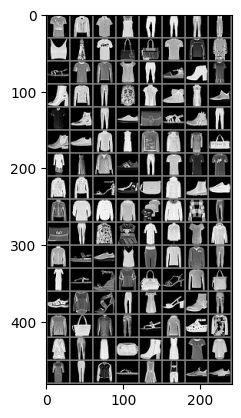

T-shirt/top Coat  Shirt T-shirt/top Trouser Trouser Trouser Trouser T-shirt/top Dress T-shirt/top Bag   Bag   T-shirt/top Pullover Dress Sandal T-shirt/top Pullover Shirt Trouser Sandal Ankle Boot Dress Ankle Boot Pullover Trouser Shirt Shirt Ankle Boot Dress Sneaker Shirt Ankle Boot Trouser Sneaker Bag   Sandal Ankle Boot Trouser Ankle Boot Sneaker Shirt Dress Pullover Coat  Dress Bag   Dress Dress T-shirt/top Sneaker Trouser T-shirt/top T-shirt/top T-shirt/top Coat  Coat  Sandal Sneaker Bag   Coat  Ankle Boot Sneaker Coat  Pullover Shirt Pullover T-shirt/top Shirt Pullover Trouser Bag   Trouser Shirt Dress Coat  Coat  T-shirt/top Coat  Coat  Sandal Sneaker T-shirt/top Trouser Pullover Pullover Trouser Dress Sandal Sandal Pullover Bag   Sandal Pullover Bag   Sandal Pullover Sandal Trouser Dress Sandal Ankle Boot Trouser Pullover Bag   Shirt Trouser Sandal Pullover Sandal Pullover Coat  Trouser Dress Bag   Ankle Boot Dress T-shirt/top Shirt Dress Trouser Coat  Sandal Dress Trouser Snea

In [3]:
# Visualize images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


## Build the Model

In [6]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv0 = nn.LazyConv2d(6,kernel_size=5,padding=2)
        self.act0 = nn.Sigmoid()
        self.pool0 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv1 = nn.LazyConv2d(16, kernel_size=5)
        self.act1 = nn.Sigmoid()
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flat = nn.Flatten()
        self.lin0 = nn.LazyLinear(120)
        self.act2 = nn.Sigmoid()
        self.lin1 = nn.LazyLinear(84)
        self.act3 = nn.Sigmoid()
        self.out = nn.LazyLinear(10)
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(10))

    def old_forward(self, X):
        out = self.conv0(X)
        out = self.act0(out)
        out = self.pool0(out)
        out = self.conv1(out)
        out = self.act1(out)
        out = self.pool1(out)
        out = self.flat(out)
        out = self.lin0(out)
        out = self.act2(out)
        out = self.lin1(out)
        out = self.act3(out)
        out = self.out(out)
        return out
    
    def forward(self, X):
        return self.net(X)

## Optimizer

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LeNet().to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
total_step = len(trainloader)
total_step

469

## Training

In [8]:
total_step = len(trainloader)
num_epochs = 20
losses = []
accuracy = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if epoch == 0:
        losses = [loss.item()]
        accuracy = [100 * correct / total]
    else:
        losses.append(loss.item())
        accuracy.append(100 * correct / total)

print('Finished Training')

Epoch [1/20], Step [400/469], Loss: 2.2965
Epoch [2/20], Step [400/469], Loss: 2.3105
Epoch [3/20], Step [400/469], Loss: 1.1175
Epoch [4/20], Step [400/469], Loss: 0.6410
Epoch [5/20], Step [400/469], Loss: 0.6098
Epoch [6/20], Step [400/469], Loss: 0.5867
Epoch [7/20], Step [400/469], Loss: 0.3871
Epoch [8/20], Step [400/469], Loss: 0.4993
Epoch [9/20], Step [400/469], Loss: 0.3361
Epoch [10/20], Step [400/469], Loss: 0.3380
Epoch [11/20], Step [400/469], Loss: 0.3208
Epoch [12/20], Step [400/469], Loss: 0.3172
Epoch [13/20], Step [400/469], Loss: 0.2622
Epoch [14/20], Step [400/469], Loss: 0.3413
Epoch [15/20], Step [400/469], Loss: 0.2936
Epoch [16/20], Step [400/469], Loss: 0.4189
Epoch [17/20], Step [400/469], Loss: 0.3184
Epoch [18/20], Step [400/469], Loss: 0.3119
Epoch [19/20], Step [400/469], Loss: 0.3766
Epoch [20/20], Step [400/469], Loss: 0.3099
Finished Training


Accuracy of the network on the 10000 test images: 87.25 %


Text(0.5, 1.0, 'Accuracy')

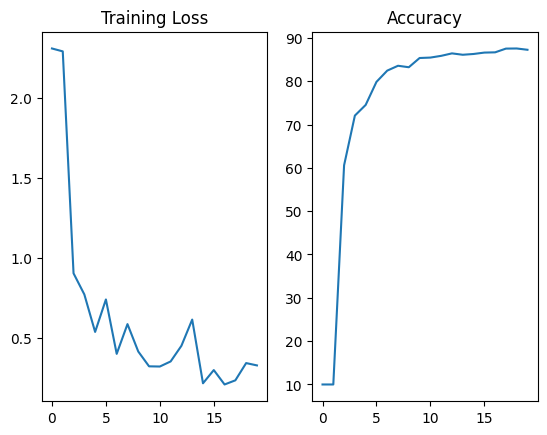

In [9]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))
plt.figure()
plt.subplot(1,2,1)
plt.plot(losses)
plt.title('Training Loss')
plt.subplot(1,2,2)
plt.plot(accuracy)
plt.title('Accuracy')